# Example 1: Batch anomaly detection service

You work for a tech-savvy taxi ride company with a fleet of thousands of cars. The organization wants to start making ride times more consistent and to understand longer journeys in order to improve customer experience and thereby increase retention and return business. Your ML team is employed to create an anomaly detection service to find rides that have unusual ride time or ride length behaviors. You all get to work, and your data scientists find that if you perform clustering on sets of rides using the features of ride distance and time, you can clearly identify outliers worth investigating by the operations team. The data scientists present the findings to the CTO and other stakeholders before getting the go-ahead to develop this into a service that will provide an outlier flag as a new field in one of the main tables of the company's internal analysis tool.

In this example, we will simulate some data to show how the taxi company's data scientists could proceed.

## Create Data

In [1]:
# data manipulation
import numpy as np
import datetime
import pandas as pd

First, let's define a function that will simulate some ride distances based on the random distribution given in numpy and return a numpy array containing the results. The reason for the repeated lines are so that we can create some base behavior and anomalies in the data, and you can clearly compare against the speeds we will generate for each set of taxis in the next step

In [2]:
np.random.RandomState(42)

RandomState(MT19937) at 0x7FB7BE515140

In [3]:
def simulate_ride_distances():
    ride_dists = np.concatenate(
        (
            10 * np.random.random(size=370),
            30 * np.random.random(size=10),
            10 * np.random.random(size=10),
            10 * np.random.random(size=10)
        )
    )
    return ride_dists


simulate_ride_distances()

array([7.03269864e+00, 4.90539774e+00, 9.70323535e+00, 1.91337865e+00,
       4.76930066e+00, 9.43318290e+00, 7.71406877e+00, 1.53156465e+00,
       3.30076083e+00, 5.72989558e+00, 3.52230386e+00, 5.34784033e+00,
       6.29172753e+00, 9.01483873e+00, 6.36424047e+00, 7.43202244e+00,
       7.33817446e+00, 4.69491871e+00, 3.98318382e+00, 1.75246608e+00,
       9.29502176e+00, 1.41009779e+00, 3.35086298e+00, 4.36008117e+00,
       3.40305940e+00, 5.74107927e+00, 5.84094762e+00, 6.46944974e+00,
       5.09143164e+00, 3.59678671e+00, 3.33235955e+00, 3.36256161e+00,
       3.99806662e+00, 6.79743974e+00, 7.15055415e+00, 7.16627570e-01,
       6.82151371e+00, 9.38975892e-01, 7.65623550e+00, 8.00782455e+00,
       2.97330967e+00, 2.06151218e+00, 3.00741517e+00, 4.30529774e+00,
       2.76431683e+00, 5.87269921e+00, 7.89115129e+00, 2.23609380e-01,
       3.83984245e+00, 1.15511922e+00, 7.48723250e+00, 4.61090161e+00,
       9.09717432e+00, 2.33939960e+00, 3.03421630e+00, 8.14593899e+00,
      

We can now do the exact same thing for speeds, and again we have split the taxis into sets of 370, 10, 10, and 10 so that we can create some data with 'typical' behavior and some sets of anomalies, while allowing for clear matching of the values with the distances function

In [4]:
?np.random.normal

In [5]:
def simulate_ride_speeds():
    ride_speeds = np.concatenate(
        (
            np.random.normal(loc=30, scale=5, size=370),
            np.random.normal(loc=30, scale=5, size=10),
            np.random.normal(loc=50, scale=10, size=10),
            np.random.normal(loc=15, scale=4, size=10)
        )
    )
    return ride_speeds


simulate_ride_speeds()

array([33.315691  , 19.03363415, 27.39348153, 34.35261604, 29.83026242,
       31.7280202 , 24.43805676, 29.08251903, 27.27634462, 26.0594368 ,
       32.35891831, 23.79884273, 34.06425159, 30.68375756, 19.74025024,
       27.86489707, 35.18706052, 28.58054482, 33.37548537, 22.24623361,
       32.04971938, 34.02498909, 45.65967764, 31.17403086, 22.26467736,
       25.30948708, 29.2999289 , 37.17354159, 37.3021577 , 26.12433175,
       25.61456655, 31.93682766, 34.7971292 , 27.49586419, 27.93166116,
       23.85084132, 35.77704581, 28.71107795, 17.15240398, 31.70033116,
       38.59120146, 28.99453118, 33.3886645 , 23.35594507, 24.87041671,
       25.40033547, 37.67782741, 32.15513274, 37.73100147, 31.53929302,
       35.81993941, 31.25152783, 26.06246283, 34.7485797 , 25.90107379,
       25.26002562, 31.20032242, 27.05347677, 22.84965031, 34.52360185,
       30.01057623, 25.63536423, 33.34167381, 25.39448781, 24.86767284,
       28.94061518, 29.89365233, 36.19659451, 29.19103053, 30.09

We can now use both of these helper functions inside a function that will call these and bring them together to create a simulated dataset containing ride IDs, speeds, distances, and times. The result is returned as a pandas DataFrame for use in modeling

In [6]:
def simulate_ride_data():
    ride_dists = simulate_ride_distances()
    ride_speeds = simulate_ride_speeds()
    ride_times = ride_dists / ride_speeds
    # Assemble into Data Frame
    df = pd.DataFrame(
        {
            'ride_dist': ride_dists,
            'ride_time': ride_times,
            'ride_speed': ride_speeds
        }
    )
    ride_ids = datetime.datetime.now().strftime("%Y%m%d") + df.index.astype(str)
    df['ride_id'] = ride_ids
    return df


simulate_ride_data()

,ride_dist,ride_time,ride_speed,ride_id
0,7.673135,0.244157,31.427109,202304240
1,3.424572,0.114706,29.855274,202304241
2,6.953350,0.244675,28.418680,202304242
3,0.873752,0.034538,25.298553,202304243
4,2.989777,0.112498,26.576279,202304244
...,...,...,...,...
395,0.368480,0.022442,16.418952,20230424395
396,3.218783,0.192316,16.736916,20230424396
397,7.259449,0.422208,17.194003,20230424397
398,2.363264,0.175979,13.429229,20230424398


In [7]:
df = simulate_ride_data()

## Explore Data

In [8]:
# visualization
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import warnings

%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15, 10)})
warnings.filterwarnings("ignore")

In [9]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ride_dist   400 non-null    float64
 1   ride_time   400 non-null    float64
 2   ride_speed  400 non-null    float64
 3   ride_id     400 non-null    object 
dtypes: float64(3), object(1)
memory usage: 12.6+ KB
None


,ride_dist,ride_time,ride_speed,ride_id
0,7.298634,0.217572,33.545801,202304240
1,3.310048,0.119124,27.786568,202304241
2,9.719871,0.359297,27.052459,202304242
3,2.416667,0.072322,33.415605,202304243
4,4.259617,0.132652,32.111315,202304244


In [10]:
df.describe()

,ride_dist,ride_time,ride_speed
count,400.000000,400.000000,400.000000
mean,5.162153,0.178584,30.439160
std,3.251361,0.133070,6.910131
min,0.030854,0.001060,8.896794
25%,2.650722,0.089060,26.868122
50%,4.973572,0.160751,30.243513
75%,7.588837,0.244034,33.408560
max,23.998471,1.153761,78.299782


<AxesSubplot:title={'center':'Ride Distance'}, ylabel='Frequency'>

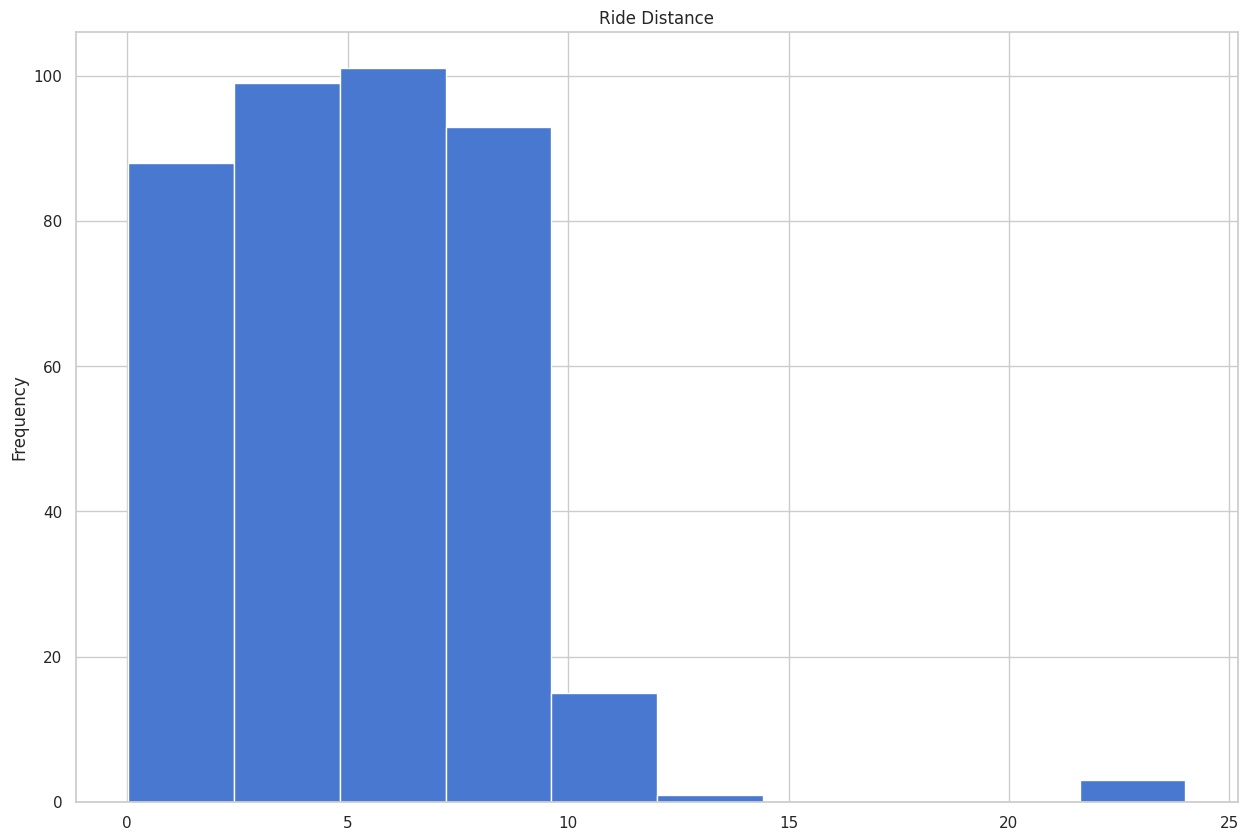

In [11]:
df.ride_dist.plot(kind='hist', title='Ride Distance')

<AxesSubplot:title={'center':'Ride Time'}, ylabel='Frequency'>

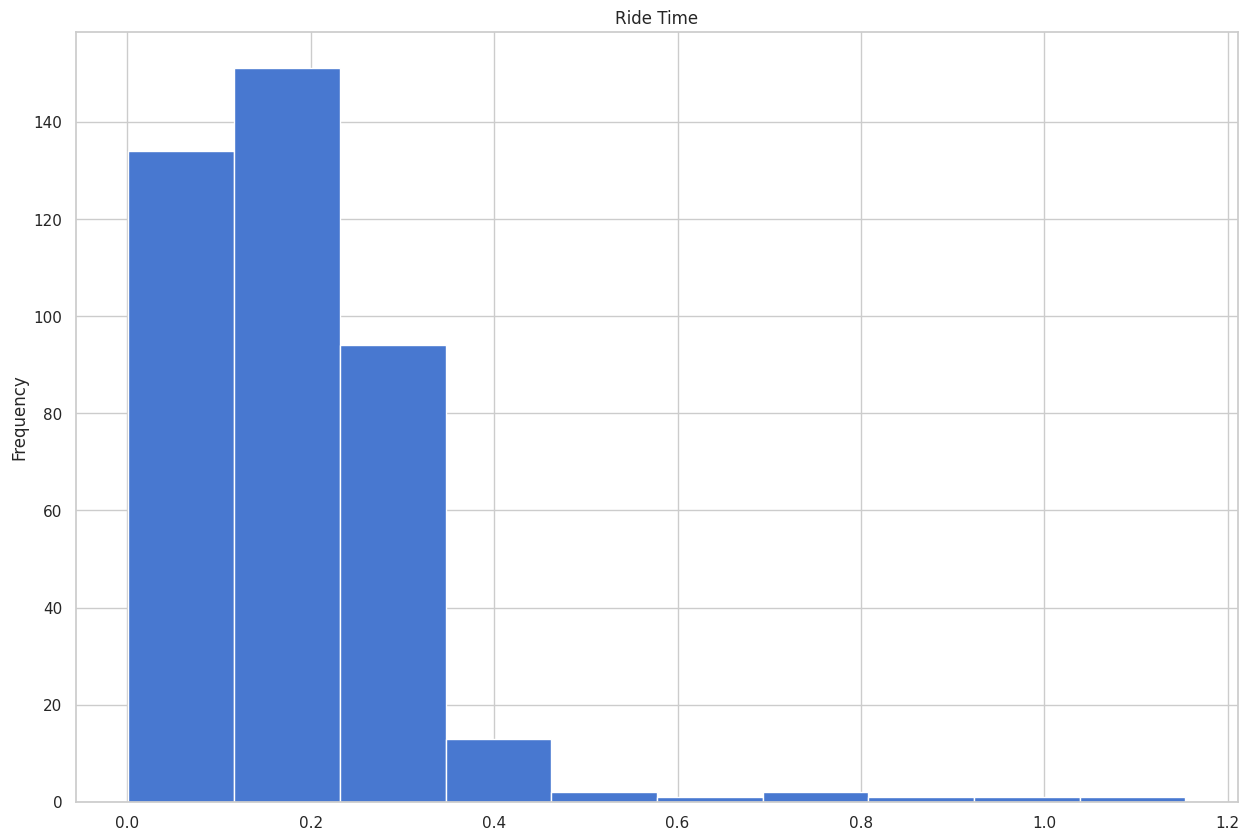

In [12]:
df.ride_time.plot(kind='hist', title='Ride Time')

<AxesSubplot:title={'center':'Ride Speed'}, ylabel='Frequency'>

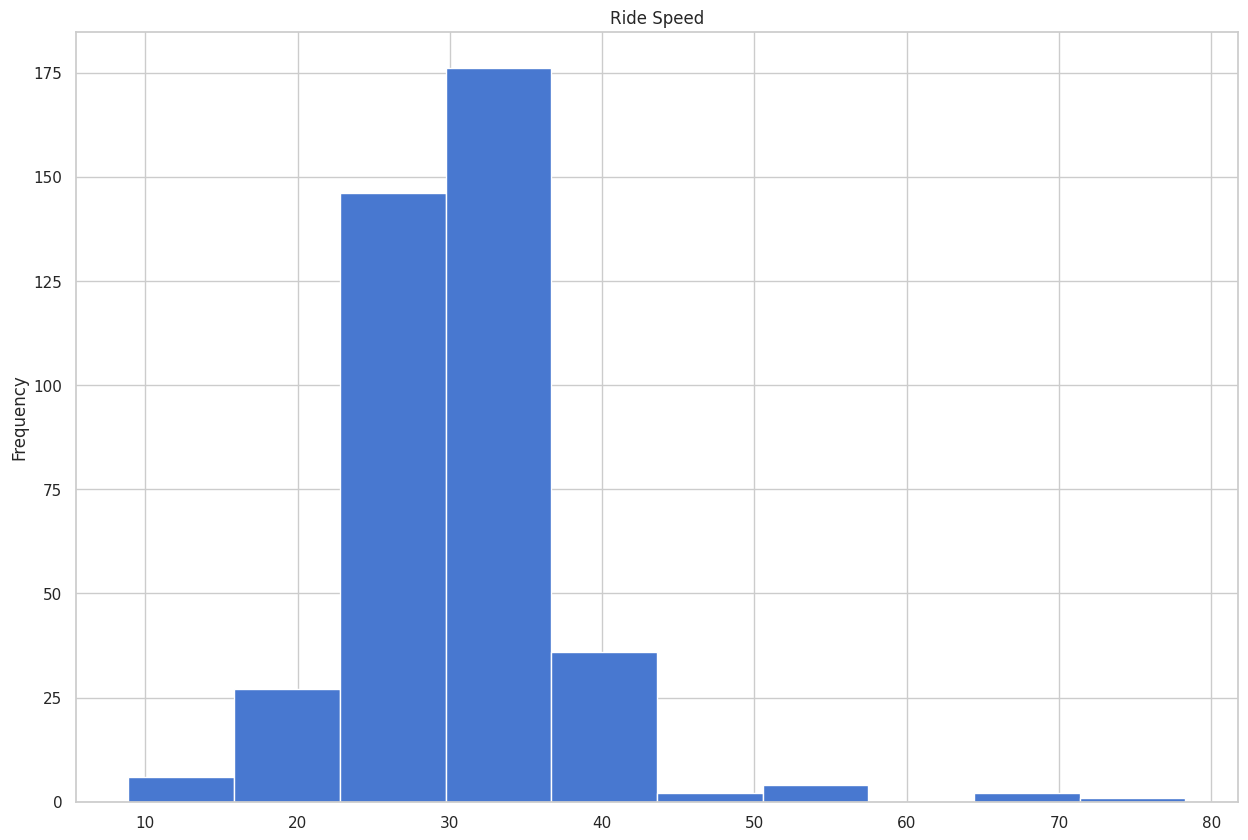

In [13]:
df.ride_speed.plot(kind='hist', title='Ride Speed')

<AxesSubplot:title={'center':'Ride Distance vs Time'}, xlabel='ride_dist', ylabel='ride_time'>

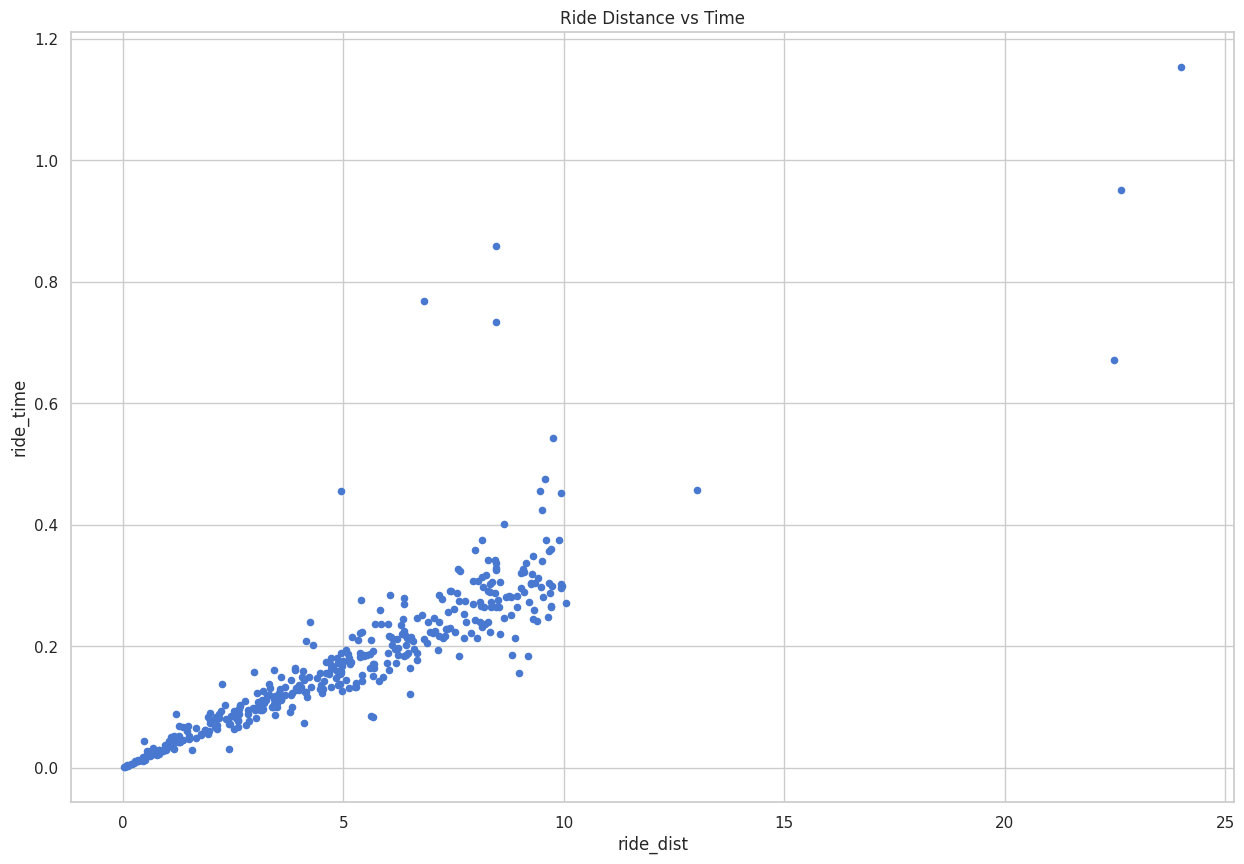

In [14]:
df.plot(kind='scatter', x='ride_dist', y='ride_time', title='Ride Distance vs Time')

<AxesSubplot:title={'center':'Ride Distance vs Speed'}, xlabel='ride_dist', ylabel='ride_speed'>

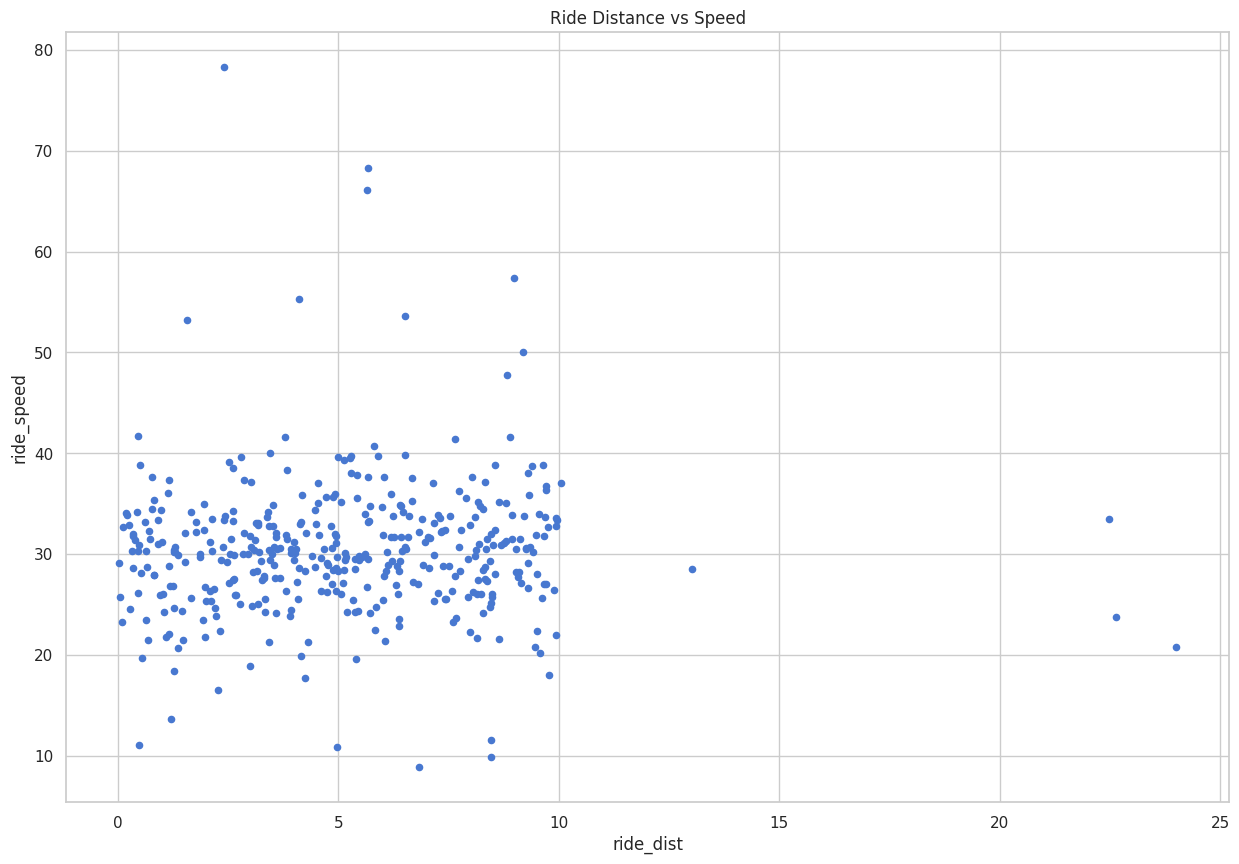

In [15]:
df.plot(kind='scatter', x='ride_dist', y='ride_speed', title='Ride Distance vs Speed')

<AxesSubplot:title={'center':'Ride Time vs Speed'}, xlabel='ride_time', ylabel='ride_speed'>

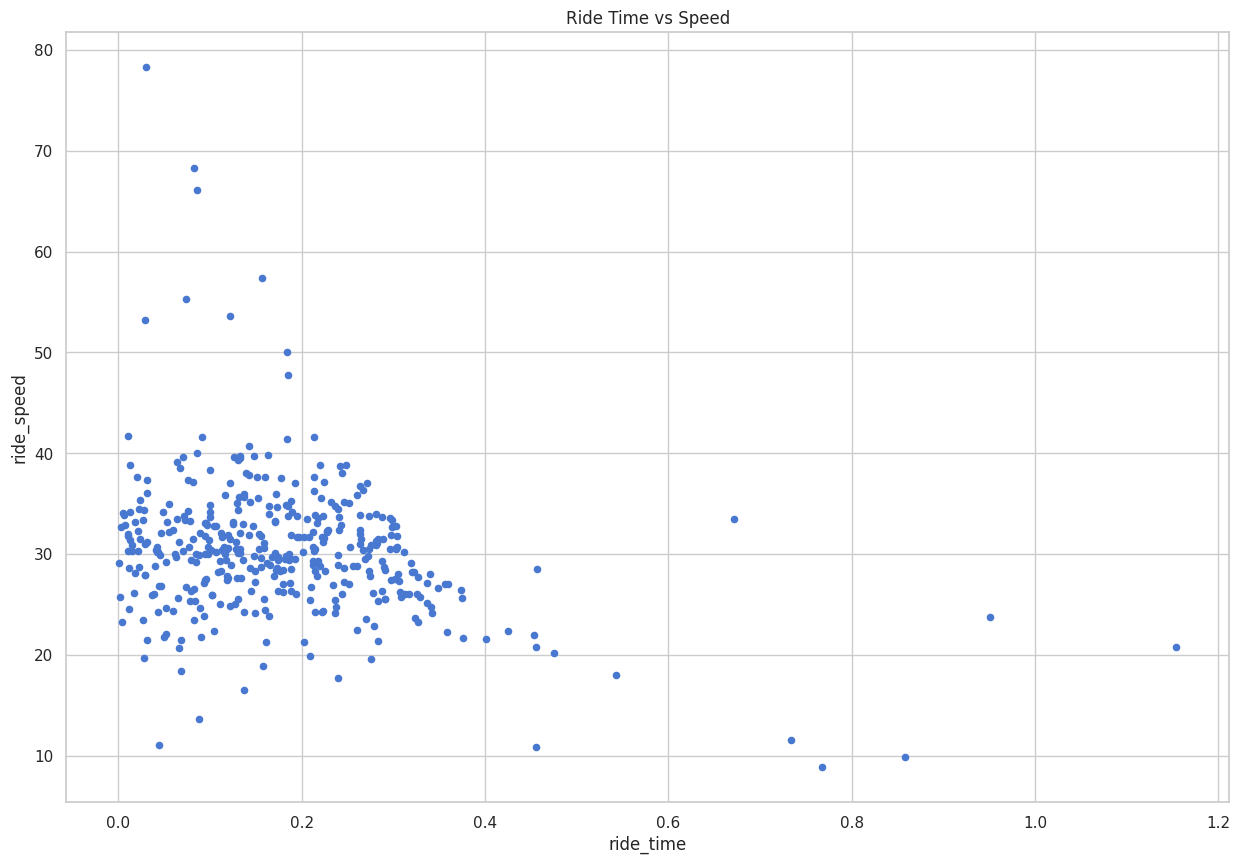

In [16]:
df.plot(kind='scatter', x='ride_time', y='ride_speed', title='Ride Time vs Speed')

## DBSCAN Clustering

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [18]:
def cluster_and_label(X, create_and_show_plot=True):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)

    # Find labels from the clustering
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    #print("Adjusted Rand Index: %0.3f"
    #      % metrics.adjusted_rand_score(labels_true, labels))
    #print("Adjusted Mutual Information: %0.3f"
    #      % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    run_metadata = {
        'nClusters': n_clusters_,
        'nNoise': n_noise_,
        'silhouetteCoefficient': metrics.silhouette_score(X, labels),
        'labels': labels,
    }
    if create_and_show_plot:
        fig = plt.figure(figsize=(10, 10))
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.cool(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels == k)
            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], '^', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

        plt.xlabel('Standard Scaled Ride Dist.')
        plt.ylabel('Standard Scaled Ride Time')
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
    else:
        pass
    return run_metadata

In [19]:
X = df[['ride_dist', 'ride_time']].values
X

array([[7.29863389e+00, 2.17572203e-01],
       [3.31004815e+00, 1.19124036e-01],
       [9.71987102e+00, 3.59297130e-01],
       [2.41666728e+00, 7.23215169e-02],
       [4.25961691e+00, 1.32651588e-01],
       [8.54836127e+00, 2.19902096e-01],
       [4.96434722e+00, 1.67155225e-01],
       [5.49883473e-01, 2.78568215e-02],
       [7.60690806e+00, 3.26576899e-01],
       [3.79470215e+00, 9.12242586e-02],
       [1.26956997e+00, 5.15546903e-02],
       [4.35416737e-01, 1.27486545e-02],
       [2.08428674e+00, 6.67302566e-02],
       [4.47731720e+00, 1.30195072e-01],
       [8.32531962e+00, 2.89460999e-01],
       [2.51526880e+00, 6.42637525e-02],
       [6.92465688e+00, 2.39642936e-01],
       [3.54419218e+00, 1.22498434e-01],
       [7.63578678e+00, 1.84459110e-01],
       [5.24674436e-01, 1.86473520e-02],
       [2.38898000e+00, 7.76751842e-02],
       [5.67779301e+00, 1.50989530e-01],
       [1.51261393e+00, 5.16971475e-02],
       [3.08692198e+00, 1.01673206e-01],
       [7.179071

Estimated number of clusters: 1
Estimated number of noise points: 17
Silhouette Coefficient: 0.607


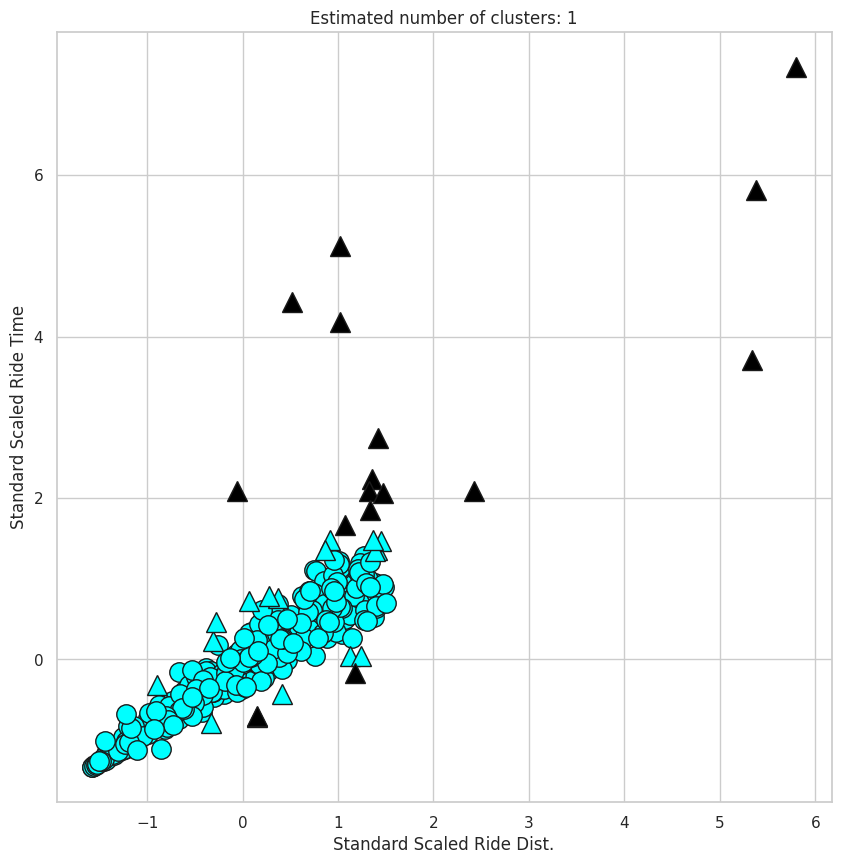

{'nClusters': 1,
 'nNoise': 17,
 'silhouetteCoefficient': 0.6072381573781488,
 'labels': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,


In [20]:
results = cluster_and_label(X)
results

## Export Results

In [21]:
import os

In [22]:
df['label'] = results['labels']
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ride_dist   400 non-null    float64
 1   ride_time   400 non-null    float64
 2   ride_speed  400 non-null    float64
 3   ride_id     400 non-null    object 
 4   label       400 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 15.8+ KB
None


,ride_dist,ride_time,ride_speed,ride_id,label
0,7.298634,0.217572,33.545801,202304240,0
1,3.310048,0.119124,27.786568,202304241,0
2,9.719871,0.359297,27.052459,202304242,0
3,2.416667,0.072322,33.415605,202304243,0
4,4.259617,0.132652,32.111315,202304244,0


<AxesSubplot:>

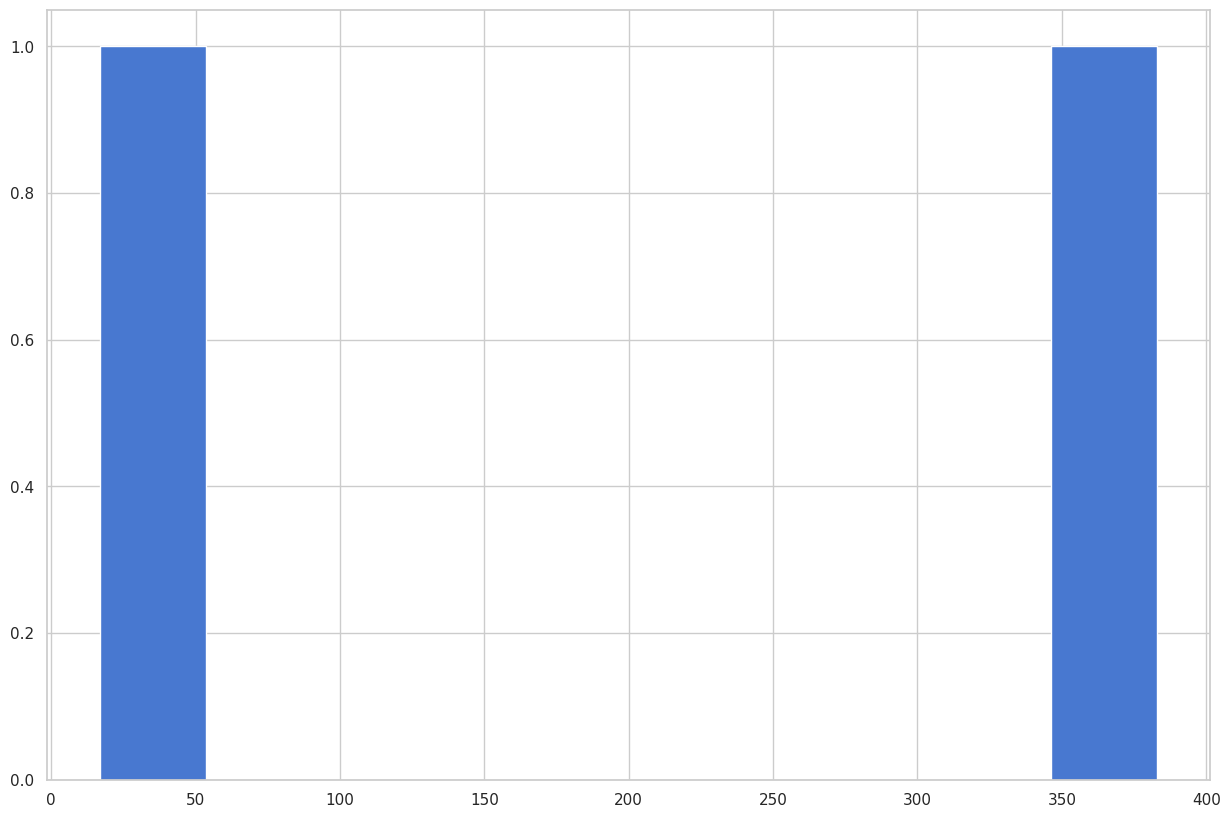

In [23]:
df.label.value_counts().hist()

In [24]:
print(os.path.exists(os.path.join('..', 'output', 'labels.json')))
df.to_json(os.path.join('..', 'output', 'labels.json'), orient='records')

False


In [25]:
df[df['label']==-1].to_json(orient='records')

'[{"ride_dist":9.5770033234,"ride_time":0.475266849,"ride_speed":20.1507917985,"ride_id":"20230424119","label":-1},{"ride_dist":8.651020173,"ride_time":0.4006998343,"ride_speed":21.5897772665,"ride_id":"20230424121","label":-1},{"ride_dist":9.467320196,"ride_time":0.4553114253,"ride_speed":20.7930652961,"ride_id":"20230424192","label":-1},{"ride_dist":9.7667784413,"ride_time":0.5427631355,"ride_speed":17.9945501148,"ride_id":"20230424199","label":-1},{"ride_dist":9.9450757643,"ride_time":0.4529450357,"ride_speed":21.9564737002,"ride_id":"20230424223","label":-1},{"ride_dist":9.5087063949,"ride_time":0.424854091,"ride_speed":22.3811105867,"ride_id":"20230424227","label":-1},{"ride_dist":23.9984705136,"ride_time":1.1537612885,"ride_speed":20.8002043002,"ride_id":"20230424375","label":-1},{"ride_dist":22.48522574,"ride_time":0.6715299892,"ride_speed":33.4835764621,"ride_id":"20230424376","label":-1},{"ride_dist":13.0292708622,"ride_time":0.4567616246,"ride_speed":28.5253185942,"ride_id":"

In [26]:
df

,ride_dist,ride_time,ride_speed,ride_id,label
0,7.298634,0.217572,33.545801,202304240,0
1,3.310048,0.119124,27.786568,202304241,0
2,9.719871,0.359297,27.052459,202304242,0
3,2.416667,0.072322,33.415605,202304243,0
4,4.259617,0.132652,32.111315,202304244,0
...,...,...,...,...,...
395,2.260673,0.137105,16.488609,20230424395,0
396,1.206357,0.088155,13.684440,20230424396,0
397,0.489164,0.044064,11.101118,20230424397,0
398,4.252131,0.239742,17.736277,20230424398,0
